# Spec2Vec - library matching
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

## Sketch idea:
1000 spectra are seleted and removed from the allGNPS_positive dataset.  
Selection is made based on:  
1. 1000 inchikeys which occur >1 times are selected randomly.
2. For each of those inchikeys one spectrum is selected randomly.

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

In [3]:
import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [4]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Evaluate inchikey occurences

In [6]:
inchikeys_pd = spectra_metadata['inchikey'][spectra_metadata['inchikey'].notnull()]
inchikeys_pd.shape

(50195,)

In [7]:
inchikeys_pd.str[:14][-10:]

90216    CCQDWIRWKWIUKK
90217    RPVIQWDFJPYNJM
90218    BXEZTCOKOLHMKY
90219    BXEZTCOKOLHMKY
90220    PVXPPJIGRGXGCY
90221    ATEFPOUAMCWAQS
90222    ILEDWLMCKZNDJK
90223    ILEDWLMCKZNDJK
90224    NCJNNMWJQIKYLO
90225    LNCLTICCQWMCNS
Name: inchikey, dtype: object

### Get inchikey (first 14 letters) occurences

In [8]:
inchikeys_pd.str[:14].value_counts()[:10]

PFTAWBLQPZVEMU    63
KMPWYEUPVWOPIM    57
MPDGHEJMBKOTSU    49
DFPMSGMNTNDNHN    46
TZBJGXHYKVUXJN    46
OXGUCUVFOIWWQJ    45
RYYVLZVUVIJVGH    45
LJOQGZACKSYWCH    45
QEVHRUUCFGRFIF    43
REFJWTPEDVJJIY    43
Name: inchikey, dtype: int64

### Plot histogram of inchikey occurences

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

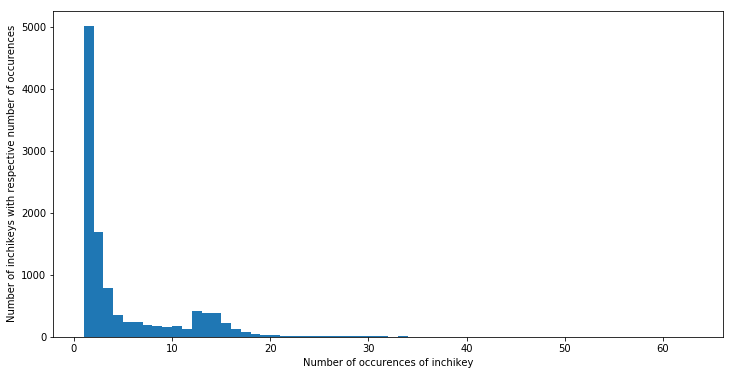

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), 62)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Select spectra to simulate libarary matching

In [10]:
import pandas as pd

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values > 1])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,PFTAWBLQPZVEMU,63
1,KMPWYEUPVWOPIM,57
2,MPDGHEJMBKOTSU,49
4,TZBJGXHYKVUXJN,46
3,DFPMSGMNTNDNHN,46
6,RYYVLZVUVIJVGH,45
5,OXGUCUVFOIWWQJ,45
7,LJOQGZACKSYWCH,45
9,REFJWTPEDVJJIY,43
8,QEVHRUUCFGRFIF,43


In [11]:
print("Number of spectra with inchikeys that exist >1 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >1 times: 5998


### Randomly select 1000 inchikeys that exist >1 times in the dataset

In [12]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:100]

[  84 2409 4996  346   79  994 4951 4078 3940 1870 4463  752 1747 3651
 1235 5426 3161 5606 3307 3194 5365 3235  530 1580 3921]


array(['COLNVLDHVKWLRT', 'NOCJXYPHIIZEHN', 'PILWRMVFWRVMAP',
       'TVKGYMYAOVADOP', 'YFGYUFNIOHWBOB', 'DHVXMTMJTVCPBB',
       'QAUDHOGPLBDVAX', 'HUSISCNTLUEZCN', 'LVTJOONKWUXEFR',
       'XDRYMKDFEDOLFX', 'XTQOUVPIWQGVEJ', 'SUAPQGLGNKUSLY',
       'HGVAHYJMDVROLE', 'VJLVPUFVTPJHDI', 'NRQCIBSGSINRCF',
       'JCHUCLMYSKXMOY', 'AEMOLEFTQBMNLQ', 'GQZDMSIXKBSDIE',
       'OTCCIMWXFLJLIA', 'YFGBQHOOROIVKG', 'KBJKWXDTUOJWAI',
       'VCKUSRYTPJJLNI', 'OJDSCNUKKOKOQJ', 'PYMYPHUHKUWMLA',
       'MDJRZSNPHZEMJH', 'URECVIHFNYVHHN', 'IXBQSRWSVIBXNC',
       'RYEFFICCPKWYML', 'VVRNYAJXAUQHEN', 'BJRNKVDFDLYUGJ',
       'BAWFJGJZGIEFAR', 'VHNBSWKVDGABEV', 'PPRFIMGXDRYLGD',
       'YPHMISFOHDHNIV', 'ZUXABONWMNSFBN', 'IJEHYEVNWOYGMS',
       'SSQAXSNCMRBPGJ', 'ZVLQJRXSGVAHOI', 'KIOWCVBPJXEJLN',
       'HVAFPBRUOUYMQM', 'LDYBFSGEBHSTOQ', 'FXGOBECSEIQDAS',
       'QVSFEOQJKPOOHP', 'VDUIGYAPSXCJFC', 'CHXSDKWBSFDZEU',
       'MGHSCXCFVZJHPT', 'PWDXABLHFDFFEB', 'LOTLMZWGLBOKFL',
       'JRJBWKJICGFLDP',

In [13]:
#suitable_inchikeys[selection].value_counts()

### Randomly pick one spectra for each of the chosen inchikeys

In [14]:
selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [15]:
# Show gnps IDs for selected spectra
spectra_metadata["gnps_ID"][selected_spectra][:10]

24236    CCMSLIB00000205644
33851    CCMSLIB00000569056
12382    CCMSLIB00000853997
39733    CCMSLIB00004696408
26281    CCMSLIB00000210444
43418    CCMSLIB00004701023
8396     CCMSLIB00000846515
11820    CCMSLIB00000852861
13423    CCMSLIB00000856134
30103    CCMSLIB00000221327
Name: gnps_ID, dtype: object

## Train new Spec2Vec model on dataset without the selected spectra

In [17]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_library.model_word2vec.alpha, "to", MS_library.model_word2vec.min_alpha_yet_reached)

Modified corpus consists of 89226 documents.
Number of unique words:  145572
Learning rate droped from 0.025 to 0.021250355837984444


### or load already trained model...

In [17]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)


Modified corpus consists of 89726 documents.
Preprocess documents...
Number of unique words:  145580
Load stored word2vec model ...


## Calculate Spec2Vec spectra vectors for all library spectra

In [18]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89226  of  89226  documents.89226  documents.  of  89226  documents. 3840  of  89226  documents. documents.  documents. 5890  of  89226  documents.  documents. documents.89226  documents. of  89226  documents. 89226  documents. documents. of  89226  documents.89226  documents. 89226  documents.89226  documents.  documents. Calculated centroid vectors for  17100  of  89226  documents.89226  documents.89226  documents. documents.  of  89226  documents. 89226  documents.  of  89226  documents. Calculated centroid vectors for  23360  of  89226  documents. of  89226  documents. of  89226  documents. of  89226  documents.  documents. of  89226  documents. 31250  of  89226  documents. of  89226  documents. 89226  documents. Calculated centroid vectors for  34670  of  89226  documents. documents. of  89226  documents. 89226  documents.  documents. documents.89226  documents.89226  do

### Save MS_library object with S2V model and calculated spectra vectors
This will save the entire SimilarityMeasures class object: MS_library.

In [20]:
MS_library.save(PATH_COMPUTED + 'MS_library_matching_unkown_spectra_191127.obj')

### Create library data by removing selected spectra

In [21]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89226, 10)

In [24]:
spectra_unknown = [spectra[x] for x in selected_spectra]
spectra_library = [spectra[x] for x in range(len(spectra)) if x not in selected_spectra]
print("Number of 'unknown' spectra:", len(spectra_unknown))
print("Number of reference spectra in library:", len(spectra_library))

Number of 'unknown' spectra: 1000
Number of reference spectra in library: 89226


In [25]:
len(MS_library.corpus)

89226

In [285]:
def library_matching(spectra_query, 
                     spectra_library,
                     library_spectra_metadata, 
                     MS_library, 
                     top_n = 10,
                     method = 'precursor_mz',
                     mz_ppm = 10,
                     spectra_vectors = None,
                     ignore_non_annotated = True,
                     extra_cosine_check = True,
                     extra_modcosine_check = True,
                     cosine_tol = 0.005):
    """
    Args:
    --------
    """
    
    # Check input data
    if len(spectra_library) != library_spectra_metadata.shape[0]:
        print("Warning! Library spectra metadata input does not match given library spectra.")
    if len(spectra_library) != len(MS_library.corpus):
        print("Warning! Library spectra input does not match dimension of given MS_library object.")
    
    # Initializations
    found_matches = []
    #for i in range(len(spectra_query)):
    #    found_matches[str(i)].append(np.array)
    
    
    mass_matches = []
    mass_cosine_matches = []
    mass_modcosine_matches = []
    S2V_matches = []
    S2V_scores = []
    multiple_matches = []
    
    if ignore_non_annotated:
        # Get array of all IDs for spectra with smiles
        annotated_spectra_IDs = np.where(library_spectra_metadata['smiles'].isna().values == False)[0]
    
    # --------------------------------------------------------------------------
    # 1. Search for Spec2Vec based matches -------------------------------------
    # --------------------------------------------------------------------------
    if method == 'Spec2Vec' or method == 'Spec2Vec_mz':
        #Check if Spec2Vec vectors are present for library
        if len(MS_library.vectors_centroid) == 0:
            print("Apparently Spec2Vec spectra vectors have not yet been derived for library data.")
            print("Spec2Vec spectra vectors will be calculated using default parameters.")
            MS_library.get_vectors_centroid(method = 'ignore', 
                                             extra_weights = None, 
                                             tfidf_weighted = False, 
                                             weight_method = 'sqrt', 
                                             tfidf_model = None,
                                             extra_epochs = 1)
        else:
            print("Spec2Vec spectra vectors found for library data.")
        
        if spectra_vectors is None:
            print("No Spec2Vec spectra vectors found for query data. Will be calculated...")
            spectra_vectors = MS_functions.vectorize_spectra(spectra_unknown,
                                                              MS_library,
                                                              num_decimals = 2,
                                                              min_loss = 5.0, 
                                                              max_loss = 500.0,
                                                              peak_loss_words = ['peak_', 'loss_'],
                                                              weighting_power = 0.5)
            
        if ignore_non_annotated:
            library_vectors = MS_library.vectors_centroid[annotated_spectra_IDs]
        else:
            library_vectors = MS_library.vectors_centroid
        M_spec2vec_similairies = 1 - spatial.distance.cdist(library_vectors, spectra_vectors, 'cosine')
        
        # Select top_n similarity values:
        Top_n = np.argpartition(M_spec2vec_similairies, -top_n, axis=0)[-top_n:,:]
        
        # Sort selected values by order
        for i in range(len(spectra_query)):
            Top_n_sorted = Top_n[:,i][np.argsort(M_spec2vec_similairies[Top_n[:,i],i])][::-1]
            if ignore_non_annotated:
                Top_n_corrected_IDs = annotated_spectra_IDs[Top_n_sorted]
            else:
                Top_n_corrected_IDs = Top_n_sorted
                
            S2V_match = list(zip(Top_n_corrected_IDs, M_spec2vec_similairies[Top_n_sorted,i]))
            S2V_matches.append(S2V_match)
                  
    # --------------------------------------------------------------------------
    # 2. Search for precursror mz based matches --------------------------------
    # --------------------------------------------------------------------------
    if method == 'precursor_mz' or method == 'Spec2Vec_mz':
        if MS_library.vectors_centroid.shape[0] != MS_library.vectors_centroid.shape[0]:
            print("Warning! Number of found Spec2Vec spectral vectors does not agree with library metadata dimension.")
        
        if ignore_non_annotated:
            library_masses = library_spectra_metadata['precursor_mz'].values[annotated_spectra_IDs]
        else:
            library_masses = library_spectra_metadata['precursor_mz'].values
        library_masses_tol = library_masses * mz_ppm/1e6
        
        # Get precursor mz for query spectra
        precursor_mz_query = []

        for spec in spectra_query:
            mass = spec.precursor_mz
            mass_match = np.where(((library_masses + library_masses_tol) > mass) & 
                                  ((library_masses - library_masses_tol) < mass))[0]
            if ignore_non_annotated:
                mass_matches.append(annotated_spectra_IDs[mass_match])
            else:
                mass_matches.append(mass_match)
    
    # --------------------------------------------------------------------------
    # 3. Combine found matches -------------------------------------------------
    # --------------------------------------------------------------------------
    for i in range(len(spectra_query)):
        IDs = list(mass_matches[i])
        mass_match_lst = len(mass_matches[i]) * [1]
        s2v_match_lst = len(mass_matches[i]) * [0]
        
        a, b = list(zip(*S2V_matches[i]))
        for m in range(len(a)):
            if a[m] in IDs:
                s2v_match_lst[IDs.index(a[m])] = b[m]
            else:
                IDs.append(a[m])
                mass_match_lst.append(0)
                s2v_match_lst.append(b[m])
        
        inchikey_match = []
        for idx in IDs:
            inchikey_match.append(1 * (spectra_library[idx].inchikey[:14] == spectra_query[i].inchikey[:14]))
        matches_df = pd.DataFrame(list(zip(IDs, mass_match_lst, s2v_match_lst, inchikey_match)),
                                       columns = ['spectra_ID', 'mass_match', 'S2V_similarity', 'inchikey_match'])
        found_matches.append(matches_df) 
    
    def intersection(lst1, lst2): 
        return list(set(lst1) & set(lst2)) 
    
    #if method == 'Spec2Vec_mz':
    #    for i in range(len(spectra_query)): 
    #        a,_ = list(zip(*S2V_matches[i]))
    #        multiple_matches.append(intersection(list(mass_matches[i]), a))
            
    if extra_cosine_check:        
        for i in range(len(spectra_query)): 
            cosine_scores = []
            for j in found_matches[i]['spectra_ID']:
                cosine_score = cosine_check(spectra_query[i],
                                            spectra_library[j],
                                            tol = cosine_tol,
                                            mod_cosine = False)
                cosine_scores.append(cosine_score)
            a, b = list(zip(*cosine_scores))
            found_matches[i]['cosine_score'] = a
            found_matches[i]['cosine_matches'] = b
                
    if extra_modcosine_check:
        for i in range(len(spectra_query)): 
            cosine_scores = []
            for j in found_matches[i]['spectra_ID']:
                cosine_score = cosine_check(spectra_query[i],
                                            spectra_library[j],
                                            tol = cosine_tol,
                                            mod_cosine = True)
                cosine_scores.append(cosine_score)
            a, b = list(zip(*cosine_scores))
            found_matches[i]['modcosine_score'] = a
            found_matches[i]['modcosine_matches'] = b
                
    return found_matches


def cosine_check(spectra1,
                 spectra2,
                 tol = 0.005,
                 mod_cosine = False):

    if mod_cosine:
        mass_shift = spectra1.parent_mz - spectra2.parent_mz
    else:
        mass_shift = None
    spec1 = np.array(spectra1.peaks, dtype=float)
    spec2 = np.array(spectra2.peaks, dtype=float)
    cosine_score = MS_sim_classic.cosine_score_greedy(spec1, 
                                                    spec2,
                                                    mass_shift = mass_shift,
                                                    tol = tol, 
                                                    min_intens = 0,
                                                    use_numba = True)
    return (cosine_score[0], len(cosine_score[1]))
        

### Calculate Spec2Vec spectra vector for query spectra

In [92]:
spectra_vectors = MS_functions.vectorize_spectra(spectra_unknown,
                                                  MS_library,
                                                  num_decimals = 2,
                                                  min_loss = 5.0, 
                                                  max_loss = 500.0,
                                                  peak_loss_words = ['peak_', 'loss_'],
                                                  weighting_power = 0.5)

TypeError: vectorize_spectra() got an unexpected keyword argument 'weighting_power'

In [223]:
S2V_matches

[]

In [128]:
ID = 0

cosine_scores = []
for x in mass_matches[ID]:
    #print(x)
    cosine_score = cosine_check(spectra_unknown[ID],
                                spectra_library[x],
                                tol = 0.005,
                                mod_cosine = False)
    cosine_scores.append(cosine_score)
    
checked_matches = np.where(np.array(list(zip(*cosine_scores))[0]) > 0.5)[0]
mass_matches[ID][checked_matches]

array([ 4551,  4666, 23793, 23794, 23795, 23934, 23935, 23936, 23937,
       29902, 29903, 29904], dtype=int64)

In [347]:
found_matches = library_matching(spectra_unknown, 
                                  spectra_library,
                                  library_spectra_metadata, 
                                  MS_library, 
                                  top_n = 10,
                                  method = 'Spec2Vec_mz',
                                  mz_ppm = 10,
                                  spectra_vectors = spectra_vectors,
                                  ignore_non_annotated = True,
                                  extra_cosine_check = True,
                                  extra_modcosine_check = True,
                                  cosine_tol = 0.05)

Spec2Vec spectra vectors found for library data.


In [311]:
found_matches[4]

,spectra_ID,mass_match,S2V_similarity,inchikey_match,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,150,1,0.929507,1,0.752878,14,0.752878,14
1,833,1,0.937713,1,0.918311,12,0.918311,12
2,886,1,0.000000,1,0.702079,15,0.702079,15
3,1344,1,0.000000,1,0.908049,14,0.908049,14
4,13720,1,0.000000,0,0.015535,12,0.015535,12
5,25799,1,0.953450,1,0.736004,12,0.736004,12
6,25800,1,0.996492,1,0.993039,13,0.993039,13
7,25801,1,0.959318,1,0.893397,12,0.893397,12
8,25802,1,0.000000,1,0.859900,12,0.859900,12
9,25803,1,0.959207,1,0.754115,12,0.754115,12


In [340]:
ID = 2
found_matches[ID][(found_matches[ID]['mass_match'] == 1) & (found_matches[ID]['modcosine_score'] > 0.5)]                                                   


,spectra_ID,mass_match,S2V_similarity,inchikey_match,cosine_score,cosine_matches,modcosine_score,modcosine_matches


In [314]:
ID = 55
found_matches[ID][(found_matches[ID]['S2V_similarity'] >0) & (found_matches[ID]['modcosine_score'] > 0.5)]

,spectra_ID,mass_match,S2V_similarity,inchikey_match,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,57471,1,0.971922,1,0.894199,79,0.894199,79
1,57472,1,0.939726,1,0.677221,73,0.677221,73
2,57503,0,0.733260,0,0.571838,63,0.571804,62
3,57504,0,0.721446,0,0.559973,66,0.559973,66
4,57236,0,0.716691,0,0.503513,60,0.504526,67
6,57609,0,0.697292,0,0.538801,60,0.550556,66
8,57612,0,0.646124,0,0.566095,47,0.573376,61


In [330]:
ID = 59
df_select = found_matches[ID][(found_matches[ID]['S2V_similarity'] >0) & (found_matches[ID]['modcosine_score'] > 0.5)]
print("best bet: ", df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match)
df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).head()


best bet:  0.0


,spectra_ID,mass_match,S2V_similarity,inchikey_match,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,12269,0,0.619149,0,0.000733,3,0.996540,34
5,10310,0,0.559409,0,0.000006,3,0.992639,27


## More extensive run through different scenarios:

In [354]:
test1_true_false = []
test2_true_false = []
test3_true_false = []
test4_true_false = []

for ID in range(len(spectra_unknown)):
    # Scenario 1: mass + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match'] == 1) & (found_matches[ID]['modcosine_score'] > 0.5)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['mass_match', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = 0
    test1_true_false.append(best_bet) 
    
    # Scenario 2:Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['S2V_similarity'] >0) & (found_matches[ID]['modcosine_score'] > 0.5)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = 0
    test2_true_false.append(best_bet)
    
    # Scenario 3: mass + mod.cosine AND as backup: Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match'] == 1) & (found_matches[ID]['modcosine_score'] > 0.5)]
    if df_select.shape[0] > 0: 
        best_bet = df_select.sort_values(by=['mass_match', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else: # no fitting masses found --> switch to backup plan
        df_select = found_matches[ID][(found_matches[ID]['S2V_similarity'] >0) & (found_matches[ID]['modcosine_score'] > 0.5)]
        if df_select.shape[0] > 0: 
            best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
        else:
            best_bet = 0
    test3_true_false.append(best_bet)
    
    # Scenario 4: mass + Spec2Vec
    df_select = found_matches[ID][(found_matches[ID]['mass_match'] == 1) & (found_matches[ID]['S2V_similarity'] >0)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = 0
    test4_true_false.append(best_bet)

In [355]:
print("Scenario 1 found matches:", np.sum(test1_true_false))
print("Scenario 2 found matches:", np.sum(test2_true_false))
print("Scenario 3 found matches:", np.sum(test3_true_false))
print("Scenario 4 found matches:", np.sum(test4_true_false))

Scenario 1 found matches: 484.0
Scenario 2 found matches: 548.0
Scenario 3 found matches: 551.0
Scenario 4 found matches: 600.0


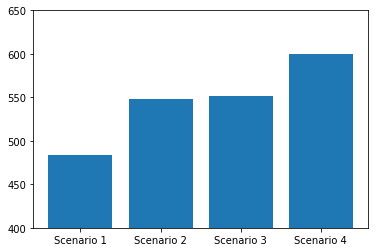

In [362]:
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
x = [np.sum(test1_true_false), np.sum(test2_true_false), np.sum(test3_true_false), np.sum(test4_true_false)]

fig, ax = plt.subplots()
plt.bar(scenarios, x)
plt.ylim(400,650)
#ticks(x, scenarios)
plt.show()